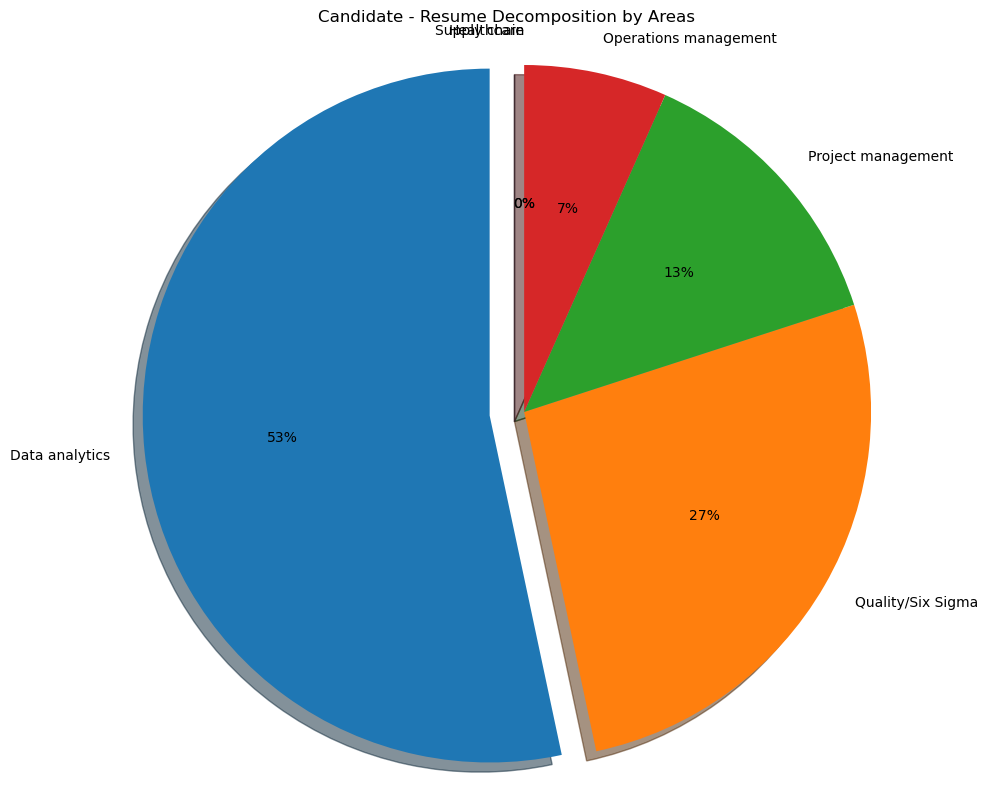

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from django.conf import settings
# Import required libraries
import PyPDF2
import textract
import docx2txt
import io
import shutil
import os
import re
import pickle
from django.conf import settings

class ResumeAnalysis():
    def __init__(self, resumedata=os.path.abspath('cvdata/UpdatedResumeDataSet.csv'),
                 result="/content/drive/MyDrive/archive (1)/augmented_dataset/",
                 rank="/content/drive/MyDrive/Datafiles/",
                 models_path=os.path.abspath('model'),
                 #resumefolder= settings.MEDIA_ROOT,
                 jobapplicationfolder=os.path.abspath('jobs')):
        self.resumedata= resumedata
        self.result = result
        self.rank = rank
        self.models_path=models_path
        #self.resumefolder=resumefolder

        self.jobapplicationfolder=jobapplicationfolder

        """## Load dataset"""
    def loaddataset(self):
        df_CV = pd.read_csv(self.resumedata)
        self.df_CV=df_CV

        """# Data exploration"""

    def dataexploration(self):
        df_CV=self.df_CV
        # Shape of dataset
        df_CV.head(10)
        df_CV.shape

        # Missing values

        print(df_CV.isnull().sum())

        df_CV.describe()

        df_CV.info()

        df_CV['Category'].unique()

        # Category unique value

        print("Category :\n", df_CV['Category'].unique())
        print("\nThe are ",len(df_CV['Category'].value_counts()),"diffrents values" )

        # Categroy repartition

        plt.figure(figsize=(20,10))
        plt.xticks(rotation=90)
        sns.countplot(x = "Category", data = df_CV)

        category = df_CV['Category'].value_counts().reset_index()
        category

        plt.figure(figsize=(15,15))
        plt.pie(category['Category'], labels=category['index'],
                colors=sns.color_palette('tab20'), autopct='%1.1f%%')
        plt.title('Category Distribution')
        plt.show()

        df_CV['Category'].value_counts()

    """# Data Cleaning"""
    def process_text(self,text,stopwords_english):
        text2 = re.sub('https:\/\/.*[\r\n]*','', text)
        text3 = re.sub(r'[^\w\s]','', text2)
        tokenizer = TweetTokenizer()
        text_mots = tokenizer.tokenize(text3)
        text_mots_lower = [word.lower() for word in text_mots]
        text_clean = [word for word in text_mots_lower if (word not in stopwords_english and len(word)>2)]
        return text_clean

    def dataexploration(self):

        ### Remove stopwords, punctuation and tokenize text
        stopwords_english = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        df_CV = self.df_CV
        df_CV["CV_clean"] = ""

        df_CV['CV_clean'] = df_CV['Resume'].apply(lambda x:self.process_text(x,stopwords_english))
        df_CV.head()
        self.df_CVclean = df_CV

    """# Data Visualization"""
    def datavisualization(self):
        # Datascience words frequency
        df_CV = self.df_CVclean
        from nltk import FreqDist
        l = list(df_CV[df_CV['Category'] == "Data Science"]['CV_clean'])
        datascience_mots = [item for sublist in l for item in sublist]
        rec_datascience_mots = FreqDist(datascience_mots)

        sns.set()
        ax = plt.figure(figsize = (15,10))
        rec_datascience_mots.plot(25)

        wordcloud = WordCloud(width = 1000, height = 500).generate(",".join(str(v) for v in rec_datascience_mots))

        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title('Wordcloud Data Science CV')

        # Sales words frequency

        from nltk import FreqDist
        l = list(df_CV[df_CV['Category'] == "Sales"]['CV_clean'])
        sales_mots = [item for sublist in l for item in sublist]
        rec_sales_mots = FreqDist(sales_mots)

        sns.set()
        ax = plt.figure(figsize = (15,10))
        rec_sales_mots.plot(25)

        wordcloud = WordCloud(width = 1000, height = 500).generate(",".join(str(v) for v in rec_sales_mots))

        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title('Wordcloud sales CV')

        # SAP Developer words frequency

        from nltk import FreqDist
        l = list(df_CV[df_CV['Category'] == "SAP Developer"]['CV_clean'])
        sap_mots = [item for sublist in l for item in sublist]
        rec_sap_mots = FreqDist(sap_mots)

        sns.set()
        ax = plt.figure(figsize = (15,10))
        rec_sap_mots.plot(25)

        wordcloud = WordCloud(width = 1000, height = 500).generate(",".join(str(v) for v in rec_sap_mots))

        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title('Wordcloud sap CV')

    """# Machine Learning"""
    def wordvectorizer(self):
        #Word vectorizer
        df_CV = self.df_CVclean
        df_ml = df_CV
        df_ml['CV_clean']

        df_ml.dtypes

        df_ml['CV_clean']=df_ml['CV_clean'].apply(lambda x:' '.join(x))
        df_ml
        requiredTarget = df_ml['Category'].values
        requiredText = df_ml['CV_clean'].values

        word_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            stop_words='english',
            max_features=266)
        word_vectorizer.fit(requiredText)
        WordFeatures = word_vectorizer.transform(requiredText)
        print(WordFeatures)
        self.df_CVml = df_ml
        self.requiredTarget = requiredTarget
        self.WordFeatures = WordFeatures

    #Train-Test
    def datatranformation(self):
        requiredTarget=self.requiredTarget
        WordFeatures=self.WordFeatures
        X_train, X_test, y_train, y_test = train_test_split(WordFeatures,requiredTarget,random_state=42, test_size=0.2,
                                                         shuffle=True, stratify=requiredTarget)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    #Prediction Model
    def Modeltraining(self):
        X_train = self.X_train
        X_test = self.X_test
        y_train = self.y_train
        y_test = self.y_test
        model = OneVsRestClassifier(KNeighborsClassifier())
        model.fit(X_train, y_train)
        self.model=model
        prediction = model.predict(X_test)
        self.prediction=prediction
        #Accuracy
        print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(model.score(X_train, y_train)))
        print('_________________________________________________________\n')
        print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(model.score(X_test, y_test)))
        prediction
        print("\n Classification report for classifier %s:\n%s\n" % (model, metrics.classification_report(y_test, prediction)))
        joblib.dump(model, self.models_path + "/model_knn.sav")

    def predicttext(self,text):
        # load the model from disk
        stopwords_english = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
                             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
                             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which",
                             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
                             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
                             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
                             "for", "with", "about", "against", "between", "into", "through", "during", "before",
                             "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over",
                             "under", "again", "further", "then", "once", "here", "there", "when", "where", "why",
                             "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no",
                             "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
                             "just", "don", "should", "now"]

        text = text.apply(lambda x: self.process_text(x, stopwords_english))
        text = text.apply(lambda x: ' '.join(x))
        loaded_model = joblib.load(self.models_path+ "/model_knn.sav")
        input=np.array(text)
        result = loaded_model.predict(input)
        return result

    def scoreresume(self,resumetext,resultpath):
        # Convert all strings to lowercase
        text = resumetext.lower()

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Create dictionary with industrial and system engineering key terms by area
        terms = {'Quality/Six Sigma': ['black belt', 'capability analysis', 'control charts', 'doe', 'dmaic', 'fishbone',
                                       'gage r&r', 'green belt', 'ishikawa', 'iso', 'kaizen', 'kpi', 'lean', 'metrics',
                                       'pdsa', 'performance improvement', 'process improvement', 'quality',
                                       'quality circles', 'quality tools', 'root cause', 'six sigma',
                                       'stability analysis', 'statistical analysis', 'tqm'],
                 'Operations management': ['automation', 'bottleneck', 'constraints', 'cycle time', 'efficiency', 'fmea',
                                           'machinery', 'maintenance', 'manufacture', 'line balancing', 'oee', 'operations',
                                           'operations research', 'optimization', 'overall equipment effectiveness',
                                           'pfmea', 'process', 'process mapping', 'production', 'resources', 'safety',
                                           'stoppage', 'value stream mapping', 'utilization'],
                 'Supply chain': ['abc analysis', 'apics', 'customer', 'customs', 'delivery', 'distribution', 'eoq', 'epq',
                                  'fleet', 'forecast', 'inventory', 'logistic', 'materials', 'outsourcing', 'procurement',
                                  'reorder point', 'rout', 'safety stock', 'scheduling', 'shipping', 'stock', 'suppliers',
                                  'third party logistics', 'transport', 'transportation', 'traffic', 'supply chain',
                                  'vendor', 'warehouse', 'wip', 'work in progress'],
                 'Project management': ['administration', 'agile', 'budget', 'cost', 'direction', 'feasibility analysis',
                                        'finance', 'kanban', 'leader', 'leadership', 'management', 'milestones', 'planning',
                                        'pmi', 'pmp', 'problem', 'project', 'risk', 'schedule', 'scrum', 'stakeholders'],
                 'Data analytics': ['analytics', 'api', 'aws', 'big data', 'business intelligence', 'clustering', 'code',
                                    'coding', 'data', 'database', 'data mining', 'data science', 'deep learning', 'hadoop',
                                    'hypothesis test', 'iot', 'internet', 'machine learning', 'modeling', 'nosql', 'nlp',
                                    'predictive', 'programming', 'python', 'r', 'sql', 'tableau', 'text mining',
                                    'visualuzation'],
                 'Healthcare': ['adverse events', 'care', 'clinic', 'cphq', 'ergonomics', 'healthcare',
                                'health care', 'health', 'hospital', 'human factors', 'medical', 'near misses',
                                'patient', 'reporting system']}

        # Initializie score counters for each area
        quality = 0
        operations = 0
        supplychain = 0
        project = 0
        data = 0
        healthcare = 0

        # Create an empty list where the scores will be stored
        scores = []

        # Obtain the scores for each area
        for area in terms.keys():

            if area == 'Quality/Six Sigma':
                for word in terms[area]:
                    if word in text:
                        quality += 1
                scores.append(quality)

            elif area == 'Operations management':
                for word in terms[area]:
                    if word in text:
                        operations += 1
                scores.append(operations)

            elif area == 'Supply chain':
                for word in terms[area]:
                    if word in text:
                        supplychain += 1
                scores.append(supplychain)

            elif area == 'Project management':
                for word in terms[area]:
                    if word in text:
                        project += 1
                scores.append(project)

            elif area == 'Data analytics':
                for word in terms[area]:
                    if word in text:
                        data += 1
                scores.append(data)

            else:
                for word in terms[area]:
                    if word in text:
                        healthcare += 1
                scores.append(healthcare)

        # Create a data frame with the scores summary
        summary = pd.DataFrame(scores, index=terms.keys(), columns=['score']).sort_values(by='score', ascending=False)
        summary

        # Create pie chart visualization
        pie = plt.figure(figsize=(10, 10))
        plt.pie(summary['score'], labels=summary.index, explode=(0.1, 0, 0, 0, 0, 0), autopct='%1.0f%%', shadow=True,
               startangle=90)
        plt.title('Candidate - Resume Decomposition by Areas')
        plt.axis('equal')

        #plt.show()

        # Save pie chart as a .png file
        pie.savefig(resultpath)
        return summary['score']

    def scoreresumeall(self, resumetext):
        # Convert all strings to lowercase
        text = resumetext.lower()

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Create dictionary with industrial and system engineering key terms by area
        terms = {
            'Quality/Six Sigma': ['black belt', 'capability analysis', 'control charts', 'doe', 'dmaic', 'fishbone',
                                  'gage r&r', 'green belt', 'ishikawa', 'iso', 'kaizen', 'kpi', 'lean', 'metrics',
                                  'pdsa', 'performance improvement', 'process improvement', 'quality',
                                  'quality circles', 'quality tools', 'root cause', 'six sigma',
                                  'stability analysis', 'statistical analysis', 'tqm'],
            'Operations management': ['automation', 'bottleneck', 'constraints', 'cycle time', 'efficiency', 'fmea',
                                      'machinery', 'maintenance', 'manufacture', 'line balancing', 'oee', 'operations',
                                      'operations research', 'optimization', 'overall equipment effectiveness',
                                      'pfmea', 'process', 'process mapping', 'production', 'resources', 'safety',
                                      'stoppage', 'value stream mapping', 'utilization'],
            'Supply chain': ['abc analysis', 'apics', 'customer', 'customs', 'delivery', 'distribution', 'eoq', 'epq',
                             'fleet', 'forecast', 'inventory', 'logistic', 'materials', 'outsourcing', 'procurement',
                             'reorder point', 'rout', 'safety stock', 'scheduling', 'shipping', 'stock', 'suppliers',
                             'third party logistics', 'transport', 'transportation', 'traffic', 'supply chain',
                             'vendor', 'warehouse', 'wip', 'work in progress'],
            'Project management': ['administration', 'agile', 'budget', 'cost', 'direction', 'feasibility analysis',
                                   'finance', 'kanban', 'leader', 'leadership', 'management', 'milestones', 'planning',
                                   'pmi', 'pmp', 'problem', 'project', 'risk', 'schedule', 'scrum', 'stakeholders'],
            'Data analytics': ['analytics', 'api', 'aws', 'big data', 'business intelligence', 'clustering', 'code',
                               'coding', 'data', 'database', 'data mining', 'data science', 'deep learning', 'hadoop',
                               'hypothesis test', 'iot', 'internet', 'machine learning', 'modeling', 'nosql', 'nlp',
                               'predictive', 'programming', 'python', 'r', 'sql', 'tableau', 'text mining',
                               'visualuzation'],
            'Healthcare': ['adverse events', 'care', 'clinic', 'cphq', 'ergonomics', 'healthcare',
                           'health care', 'health', 'hospital', 'human factors', 'medical', 'near misses',
                           'patient', 'reporting system']}

        # Initializie score counters for each area
        quality = 0
        operations = 0
        supplychain = 0
        project = 0
        data = 0
        healthcare = 0

        # Create an empty list where the scores will be stored
        scores = []

        # Obtain the scores for each area
        for area in terms.keys():

            if area == 'Quality/Six Sigma':
                for word in terms[area]:
                    if word in text:
                        quality += 1
                scores.append(quality)

            elif area == 'Operations management':
                for word in terms[area]:
                    if word in text:
                        operations += 1
                scores.append(operations)

            elif area == 'Supply chain':
                for word in terms[area]:
                    if word in text:
                        supplychain += 1
                scores.append(supplychain)

            elif area == 'Project management':
                for word in terms[area]:
                    if word in text:
                        project += 1
                scores.append(project)

            elif area == 'Data analytics':
                for word in terms[area]:
                    if word in text:
                        data += 1
                scores.append(data)

            else:
                for word in terms[area]:
                    if word in text:
                        healthcare += 1
                scores.append(healthcare)

        # Create a data frame with the scores summary
        summary = pd.DataFrame(scores, index=terms.keys(), columns=['score']).sort_values(by='score', ascending=False)
        summary

        return summary['score']
    def pdftotext(self,filepath):
        # Open pdf file
        pdfFileObj = open(filepath, 'rb')

        # Read file
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

        # Get total number of pages
        num_pages = pdfReader.numPages

        # Initialize a count for the number of pages
        count = 0

        # Initialize a text empty etring variable
        text = ""

        # Extract text from every page on the file
        while count < num_pages:
            pageObj = pdfReader.getPage(count)
            count += 1
            text += pageObj.extractText()
        return text


    def extract_text_from_docx(self,docx_path):
        txt = docx2txt.process(docx_path)
        if txt:
            return txt.replace('\t', ' ')
        return None

    def convertresumefileToText(self,filepath):
        text =" "
        fileExtension = filepath.split(".")[-1]
        if fileExtension == "docx":
            text = self.extract_text_from_docx(filepath)
        elif fileExtension == "pdf":
            text = self.pdftotext(filepath)
        return text

def rankall(ROOT,applicantnames):
    ResumeAnalysisob = ResumeAnalysis()
    resumefilepath= ROOT
    cvsresults=pd.DataFrame(columns=['Resumepath','Data analytics','Quality/Six Sigma','Operations management','Supply chain','Project management','Healthcare'])
    #result=pd.DataFrame()
    columns=['Data analytics', 'Quality/Six Sigma', 'Operations management', 'Supply chain', 'Project management', 'Healthcare']
    files=applicantnames
    for i in range(0,len(files)):
        print(files[i]+'.pdf')
        text= ResumeAnalysisob.convertresumefileToText(resumefilepath+files[i]+'.pdf')
        #predictedclass= self.predicttext(text)
        result=ResumeAnalysisob.scoreresumeall(text)
        categories=list(result.index)
        cvscat = dict(result)
        catresults=[]
        for j in range(0,len(columns)):
            for category in categories:
                if columns[j] == category:
                    result=cvscat[category]
                    catresults.append(result)
        print(catresults)
        cvsresults.loc[i]=[files[i]]+catresults
        #for j in range(0,len(categories)):
        #    cvscat.loc[i]=[result[categories[j]]]
    print(cvsresults)
    #resultcategory1 = result.sort_values('Courses', ascending=False)
    #cvsresults.to_csv( resumefilepath+ 'cvinfo.csv')
    return cvsresults

def cvanalysis(filepath,resultpath):
    resumefilepath= filepath
    ResumeAnalysisob = ResumeAnalysis()
    text= ResumeAnalysisob.convertresumefileToText(filepath)
        #predictedclass= self.predicttext(text)
    result=ResumeAnalysisob.scoreresume(text,resultpath)
    Resumepath=filepath
    CV=text
    Categories=list(result.index)
    Score=result
    return Resumepath,CV,Categories,Score

if __name__ == '__main__':
    ResumeAnalysisob=ResumeAnalysis()
    #ResumeAnalysisob.loaddataset()
    #ResumeAnalysisob.dataexploration()
    #ResumeAnalysisob.wordvectorizer()
    #ResumeAnalysisob.datatranformation()
    #ResumeAnalysisob.Modeltraining()
    #ResumeAnalysisob.rankall()
    cvanalysis(os.path.abspath('media/DURGESH BABU P.pdf'),os.path.abspath('media/DURGESH BABU P.png'))
#     cvanalysis(os.path.abspath('media/Gagan Resume.pdf'),os.path.abspath('media/Gagan Resume.png'))
#     cvanalysis(os.path.abspath('media/Resume.pdf'),os.path.abspath('media/Resume.png'))